# Прогнозирование временных рядов

На этой лекции мы поговорим о задаче прогнозирования временных рядов, т.е. таких данных у которых есть только время замера и значение замеренной величины. При этом расстояние между всеми замерами одинаковое. Например, первый датасет который мы рассмотрим - это месяные показатели продад шампуня. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np

In [12]:
!pwd

/content


In [13]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Technopark/Sem_6/TimeSeriesDataset

currency.csv	 Melbourne.csv	Station1.png  Station3.png
electricity.csv  shampoo.csv	Station2.png


In [14]:
dateparse_shampoo = lambda x: pd.datetime.strptime(x, '%Y-%m')

shampoo = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Technopark/Sem_6/TimeSeriesDataset/shampoo.csv', index_col=['Month'], parse_dates=['Month'], date_parser=dateparse_shampoo)
shampoo.columns = ['Sales']
shampoo['MonthNum'] = shampoo.reset_index().index
shampoo.head()

,Sales,MonthNum
Month,,
2001-02-01,145.9,0
2001-03-01,183.1,1
2001-04-01,119.3,2
2001-01-01,266.0,3
2001-05-01,180.3,4


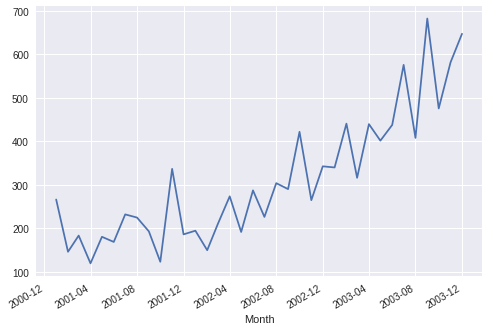

In [15]:
shampoo['Sales'].plot()

Второй датасет - это минимальная температура в городе Мельбурн, Австралия

In [18]:
dateparse_mel = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

melbourne = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Technopark/Sem_6/TimeSeriesDataset/Melbourne.csv', sep=';', index_col=['Date'], parse_dates=['Date'], date_parser=dateparse_mel)
melbourne.columns = ['temp']
melbourne['days'] = np.apply_along_axis(lambda x: (x-melbourne.index.values[0]).astype(np.long)/86400000000000, 0, melbourne.index.values )
melbourne.head()

,temp,days
Date,,
1981-01-01,20.7,0.0
1981-01-02,17.9,1.0
1981-01-03,18.8,2.0
1981-01-04,14.6,3.0
1981-01-05,15.8,4.0


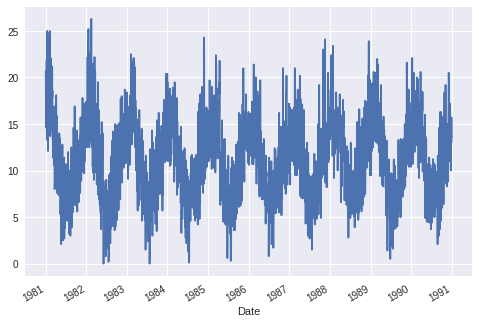

In [19]:
melbourne['temp'].plot()

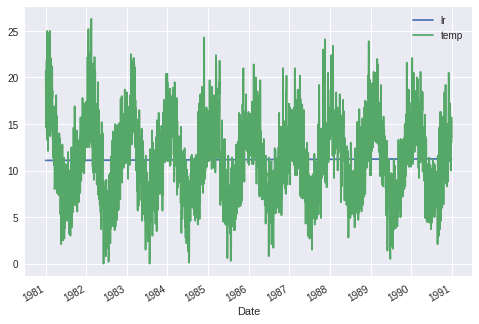

In [20]:
from sklearn.linear_model import LinearRegression 
lr_m = LinearRegression()
lr_m.fit(melbourne.days.values.reshape(-1,1),melbourne.temp)
melbourne['lr'] = lr_m.predict(melbourne.days.values.reshape(-1,1))
melbourne[['lr','temp']].plot()

Если присмотреться к этой картинке, то видно, что предсказание получилось не очень хорошее ( а честно говоря, совсем плохое), хотя в данных совершенно точно есть структура. С данными по шампуню можно получить результат лучше, но он все-равно не идеален.

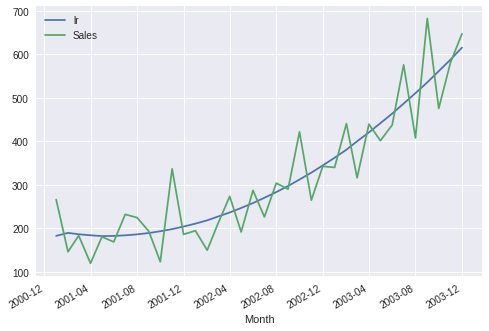

In [21]:
lr_s = LinearRegression()
lr_s.fit(np.hstack([shampoo.MonthNum.values.reshape(-1,1),shampoo.MonthNum.values.reshape(-1,1)**2] ) ,shampoo.Sales)
shampoo['lr'] = lr_s.predict(np.hstack([shampoo.MonthNum.values.reshape(-1,1),shampoo.MonthNum.values.reshape(-1,1)**2]))
shampoo[['lr','Sales']].plot()

# Разложение  ряда на составляющие 

Классически временные ряды разделяют на 4 части:


1.   **Тренд** -   плавное долгосрочное не цикличное изменение значений ряда.  Например, постоянный линейный рост 
2.    **Сезонность** -  циклические изменения значений ряда с постоянным периодом. Например на графике температуры, можно заметить цикл длиной в год - так летом темература выше, а зимой - ниже.
3.   **Цикличность** - циклические изменения значения ряда с переменным и большим периодом. Так, например, в погодных колебаниях есть более крупные периоды в 10-15 лет, когда средняя температура за зиму плавно поднимается, а потом падает в течении данного периода
4.   **Случайный шум**  - в любом процессе есть элемент случайности, который невозможно описать никакими формулами или алгоритмами - она и является случайной составляющей. На практике - это "наблюдаемые значения" - "тренд" - "цикличность" - "сезонность"


Погоду легко разложить на эти составляющие:


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


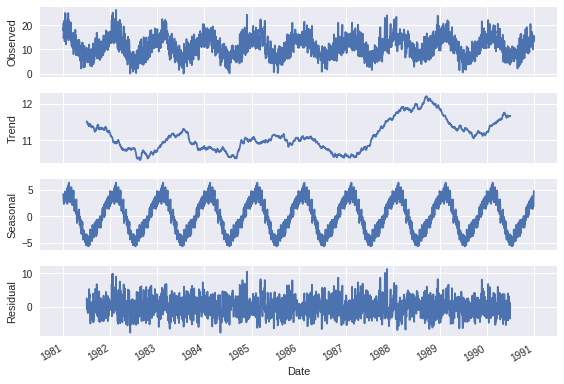

In [22]:
from random import randrange
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(melbourne['temp'], model='additive',freq=365)
result.plot()
plt.show()

Если мы здесь знали размер сезонного цикла - 365 дней, то для шампуня с сезонностью сложнее


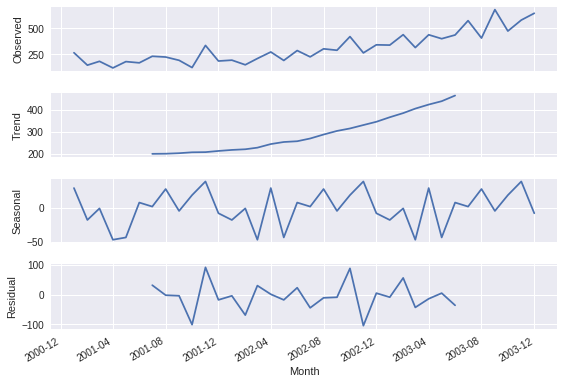

In [23]:
result = seasonal_decompose(shampoo['Sales'], model='addative',freq=12)
result.plot()
plt.show()

# Автокорелляция

Посмотрим, как зависят значения во временном ряду от значения предыдущих наблюдений

Shift =  1


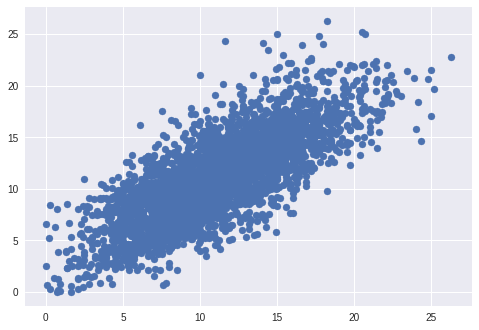

Shift =  30


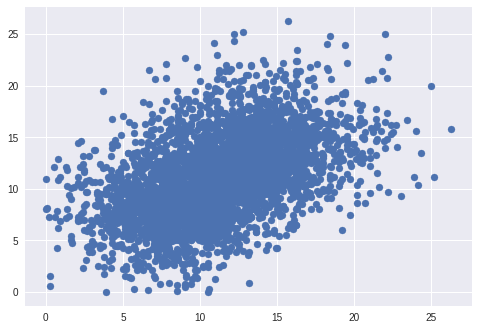

Shift =  60


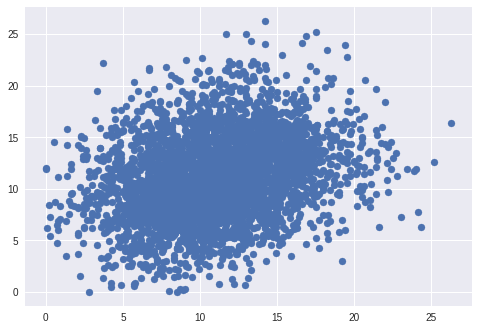

Shift =  365


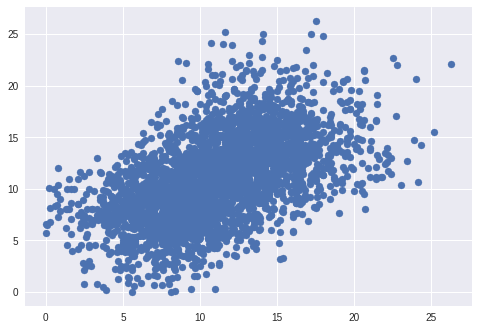

In [24]:
from matplotlib.pyplot import scatter
from matplotlib import pyplot as plt
shifts = [1,30,60,365]
for shift in shifts:
  print( "Shift = ", shift)
  scatter(melbourne['temp'].values[shift:],melbourne['temp'].values[:-shift])
  plt.show()

Как видно на графиках выше - имеют связь между собой соседние дни и дни с расстоянием в год, значения находящиеся на другом расстоянии друго от друга - практически не имеют никакой связи.

На практике для оценки этого эффекта есть математическая величина : автокорреляция. Вычисляется она как корелляция Пирсона для рядов : *TimeSeries[shift:]* и *TimeSeries[:-shift]* или:

$r_{shift} = \frac{\mathbb{E}((TimeSeries_t - \mathbb{E}TimeSeries )(TimeSeries_{t+shift} - \mathbb{E}TimeSeries ))}{\mathbb{D}TimeSeries}$

если на практике, то мат.ожидание заменяется на выборочное среднее, а дисперсия заменяется на выборочную дисперсию

$r_{shift} = \frac{\sum((TimeSeries_t - \overline{TimeSeries} )(TimeSeries_{t+shift} - \overline{TimeSeries}))}{\sum(TimeSeries - \overline{TimeSeries })^2}$


Для того, чтобы определить лучшие значения сдвига для автокорелляции рисуют королеллограммы:


(array([-720, -719, -718, ...,  718,  719,  720]),
 array([0.75235612, 0.75167365, 0.7519235 , ..., 0.7519235 , 0.75167365,
        0.75235612]),
 <matplotlib.lines.Line2D at 0x7f17fbd282e8>)

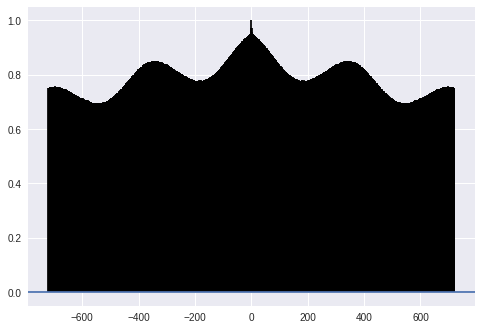

In [25]:
  plt.acorr(melbourne.temp, maxlags = 720)

или

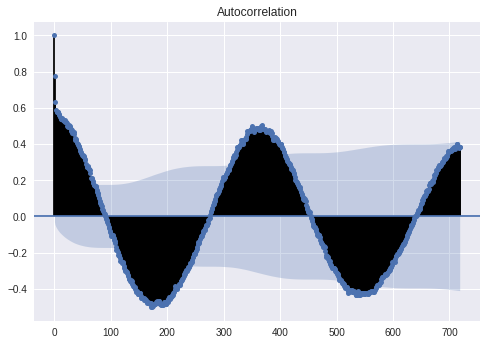

In [26]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(melbourne.temp, lags=range(720), alpha=0.05)
plt.show()

Полупрозрачнм цветом отмечена область 95% доверительного интервала. Это значит, что все значения лага/сдвига, автокорелляция которых не лежит в  этой области - -  автокореллированы с 95% уровнем значимости

# Стационарность

Еще одно важное свойство  ряда - это стационарность. Если говорить формальным языком, то процесс называется стационарым "в шикором смысле", если:
1. $$\forall t : \exists \mathbb{E}TimeSeries_t\text{ и }\exists \mathbb{D}TimeSeries_t\neq 0$$
2. $$\forall t_1,t_2 : \mathbb{E}TimeSeries_{t_1} = \mathbb{E}TimeSeries_{t_2} $$
3. $$\forall s \in \mathbb{R} : cov( TimeSeries_{t}, TimeSeries_{t+s} ) = K(t, t+s) = K'(s)$$

Но это если говорить скучным и формальным языком, если говорить простым языком, то стационарным считается ряд, поведение которого с течением времени не изменяется. 

Давайте обратимся к доске и попробуем отличить "на вскидку" стационарные ряды от не стационарных.


**внимание на доску**

![alt text](https://lh5.googleusercontent.com/QimyQNXR4YO9fIc7GSe7y8d3wS-adIxHu2bmBnrYrVMFkNQG5EyGJTKMVLTom-q3hsQJhVqYjp00_0B1tFc7=w1858-h929)
![alt text](https://lh6.googleusercontent.com/xZ0JPxVV6O1H1ZighJFsWik9m2l_U5Y5jENicBI6N_S5QR8PxrZcrY_fCFBLEWoeN6RITMFSNCTYtP6upDLP=w1858-h929)
![alt text](https://lh6.googleusercontent.com/qag_9ImCZDyzae3TddGxPPps0lbZt0LpC9uv36d_gHiUgDGslAFLy1igEra1uUxA8E--71ZN7d32Ledu4_bR=w1858-h929)

Как вы видите, смотря на график ряда - уже можно сказать, стационарен он или нет.  Так как машинное обучение - точная наука, то и есть и строгий математический способ проверить  - это проверка гипотез. Способ статистически проверить стационарность ряда целое множество. Самым часто используемым, а самое приятное - реализованным в Python - является   критерий Дики-Фуллера .



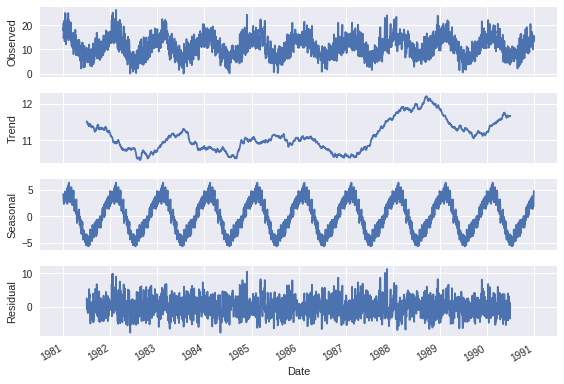

Dickey-Fuller p-value: 0.0


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
result = seasonal_decompose(melbourne['temp'], model='additive', freq=365)
result.plot()
plt.show()
print("Dickey-Fuller p-value:", sm.tsa.stattools.adfuller(result.resid[365:-265])[1])

In [0]:
print("Dickey-Fuller p-value:", sm.tsa.stattools.adfuller(result.seasonal[365:-365])[1])

Dickey-Fuller p-value: 0.0001773654557737509


Как видно из примера выше - если из ряда температуры в Мельбурне вычесть  сезонную компоненту и тренд, то останется стационарный ряд и это хорошо, а почему - увидим дальше

In [0]:
dateparse_el = lambda x: pd.datetime.strptime(x, '%Y-%m')

electricity = pd.read_csv('/content/gdrive/My Drive/TechnoPark/TimeSeriesDataset/electricity.csv', sep=',', index_col=['Month'], parse_dates=['Month'], date_parser=dateparse_el)
electricity.columns = ['gigawatts']
electricity['months'] = electricity.reset_index().index
electricity.head()

,gigawatts,months
Month,,
1956-01-01,1254,0
1956-02-01,1290,1
1956-03-01,1379,2
1956-04-01,1346,3
1956-05-01,1535,4


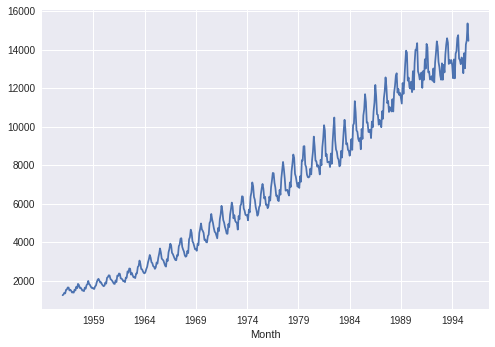

In [0]:
electricity['gigawatts'].plot()

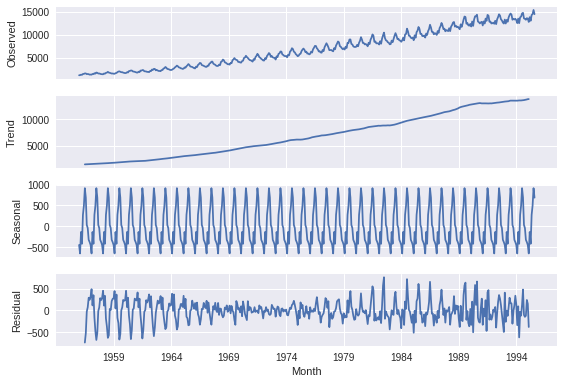

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
result = seasonal_decompose(electricity['gigawatts'], model='additive', freq=12)
result.plot()
plt.show()

Как видно из картинки ряд с показателем производства электрическва в Австралии имеет дисперсию растущую с течением времени. Это тоже плохо и с этим надо разбираться. 

# Коробка кокса

Для решения проблемы изменяющейся дисперсии создано было придумано преобразование Бокса-Кокса:

$${\displaystyle boxcox(TimeSeries, \lambda )={\begin{cases}{\dfrac {TimeSeries^{\lambda }-1}{\lambda }}&{\text{if }}\lambda \neq 0,\\\ln TimeSeries&{\text{if }}\lambda =0,\end{cases}}}$$

и оно реализовано в Python!

Но... есть засада - обратное преобразование в библиотеках Python  - не реализовано и его приходится подключать/реализовывать самостоятельно.



In [0]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Lambda: 0.3896252474492478


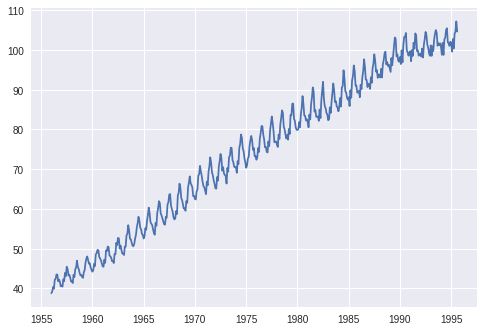

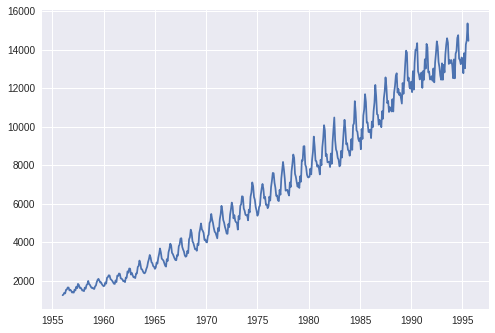

In [0]:
import scipy.stats as scs
electricity_2 = electricity.copy()
electricity_2['gigawatts_box'], lmbda = scs.boxcox(electricity_2.gigawatts) 
print( "Lambda:", lmbda)
plt.plot( electricity_2['gigawatts_box'] )
plt.show()
plt.plot( electricity['gigawatts'] )
plt.show()

Как видите, функция сама подобрала параметр $\lambda$ и применила преобразование Бокса-Кокса к ряду и дисперсия теперь одинаковая на протяжении всего времени

# Дифференцирование
Рассмотрим последнее преобразование над рядами, которое может помочь, если все совсем плохо - это дифференцирование. 

Новость хорошая: для выполнения операции дифференцирования не надо вычислять пределы: $TimeSeries'_t = TimeSeries_t-TimeSeries_{t-1}$ 

Новость плохая: дифференцировать бесконечно невозможно, так как при дифференцировании длина ряда сокращается

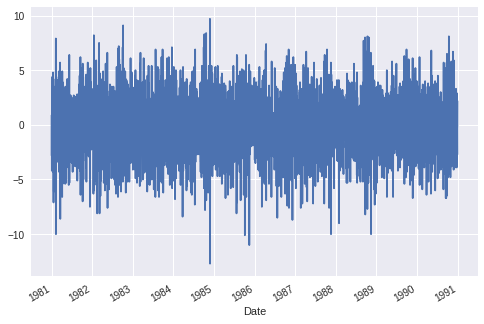

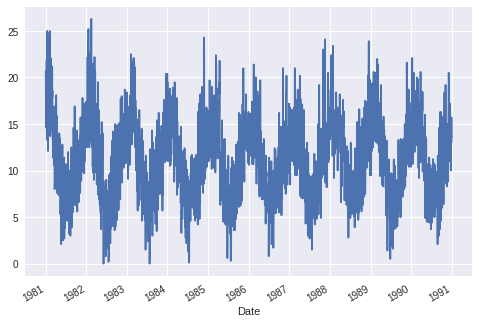

In [0]:
melbourne['diff'] = np.hstack( ([np.nan], (melbourne.temp.values[1:] - melbourne.temp.values[:-1])  ))
melbourne['diff'].plot()
plt.show()
melbourne.temp.plot()
plt.show()

# Теперь изучим алфавит моделей для прогнозирования временных рядов: S, AR, I, MA, X 
 
 ## AR - авторегрессия. 
 
 В методе авторегрессии $AR(TimeSeries, p )$ решается задача обычной регрессии для следующего уравнения:
 
 $$TimeSeries_t = \alpha + \sum_{i=1}^pa_i^{AR} TimeSeries_{t-i}$$
 
 Т.е. мы пытаемся предсказать следующее значение ряда по $p$ предыдущим. 
 

In [0]:

import statsmodels.api as sm

##MA -- скользящее среднее

Идея ничем не отличает от преддущей, только в этом случае мы строим прогноз не на основе всего временного ряда, а на основе только его шумовой компоненты: 
 
 $$MA(TimeSeries, q)_t  = \alpha + \sum_{i=1}^qa_i^{MA} TimeSeriesNoie_{t-i}$$
 
 
##ARMA -- комбинация двух предыдущих моделей
 
 $$ARMA_t(TimeSeries, p, q)  = \alpha + \sum_{i=1}^pa_i^{AR} TimeSeries_{t-i} + \sum_{i=1}^qa_i^{MA} TimeSeriesNoie_{t-i}$$
 
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is

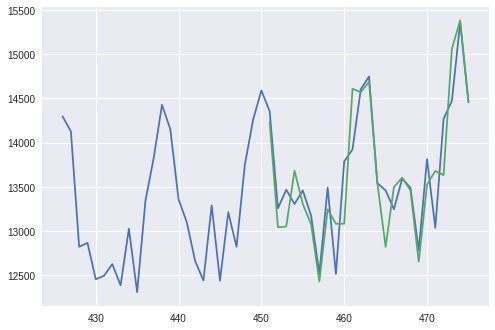

In [0]:


mdl = smt.ARMA(np.asarray(electricity.gigawatts.values, dtype=np.float64), order=(2, 2)).fit(maxlag=30, ic='aic', trend='c')

prediction = mdl.predict(start = electricity.gigawatts.values.shape[0] - 24, end = electricity.gigawatts.values.shape[0])
plt.plot(electricity.months.values[-50: ], electricity.gigawatts.values[-50: ])
plt.plot(electricity.months.values[-25: ], prediction)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


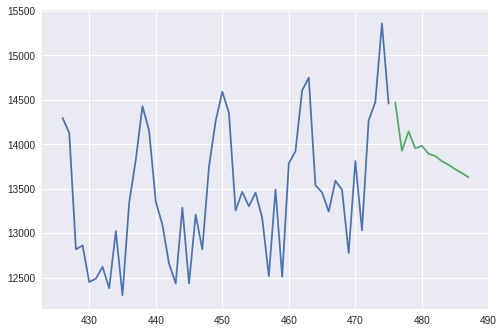

In [0]:
prediction =  mdl.forecast(12)[0]
plt.plot(electricity.months.values[-50: ], electricity.gigawatts.values[-50: ])
plt.plot(electricity.months.values[-12: ] + 12, prediction)
plt.show()

большой и важный минус моделей типа ARMA - это требование к стационарности ряда, который поступает на вход. В случае нестационарности модель может давать плохие результаты или вообще не сойтись. 


Но на есть две фундаментальные теоремы: 

На данный момент известны два факта:

1. Теорема Вольда: любой стационарный ряд может быть описан моделью ARMA(p, q) с любой наперёд
заданной точностью.
2. При помощи дифференцирования нестационарный ряд можно сделать стационарным

из них появляется новая буква : 

## I  - дифференцирование и модель ARIMA

$$ARIMA(TimeSeries, p, q, d) = \underbrace{\int\dots\int}_{n} ARMA(TimeSeries^{(d)}, p, q)$$



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


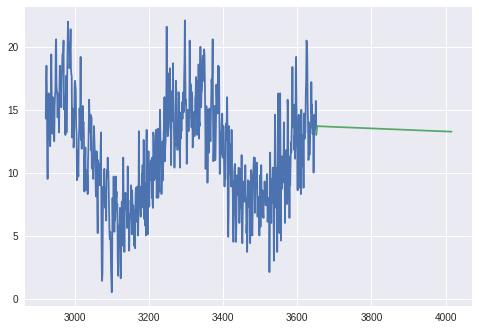

                             ARIMA Model Results                              
Dep. Variable:                 D.temp   No. Observations:                 3649
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8386.371
Method:                       css-mle   S.D. of innovations              2.409
Date:                Wed, 14 Nov 2018   AIC                          16784.742
Time:                        16:56:21   BIC                          16821.955
Sample:                    01-02-1981   HQIC                         16797.995
                         - 12-31-1990                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0012      0.006     -0.193      0.847      -0.013       0.011
ar.L1.D.temp     0.4853      0.139      3.490      0.000       0.213       0.758
ar.L2.D.temp    -0.1243      0.067     -1.85

In [0]:
mdl = smt.ARIMA(melbourne.temp, order = (2,1,2)).fit(method='css-mle', trend='c')

prediction = mdl.forecast(365)
plt.plot(melbourne.days.values[-730: ], melbourne.temp.values[-730: ])
plt.plot(melbourne.days.values[-365: ]+365, prediction[0])
plt.show()
print(mdl.summary())

## S - сезонность и модели SARMA и SARIMA

Добавляем в модель информаци о сезонности: 
 
 $$SARMA_t(TimeSeries, p, q)\times(P,Q)  = \alpha + \sum_{i=1}^pa_i^{AR} TimeSeries_{t-i}$$
 $$ + \sum_{i=1}^qa_i^{MA} TimeSeriesNoise_{t-iS}$$
 
 $$ + \sum_{i=1}^Pa_i^{SAR} TimeSeries_{t-iS} + \sum_{i=1}^Qa_i^{SMA} TimeSeriesNoise_{t-iS}$$
 
 Вслучае с SARIMA - добавляется еще сезонное дифференцирование. $SARIMA_t(TimeSeries, p, d, q)\times(P,D,Q)$

# X - регрессионный подход

Модели SARIMAX - это модели в которых сначала применяется модель линейной регрессии, а потом уже, методами SARIMA предсказывается отклонение ряда от результата линейной регрессии

In [0]:
#mdl = smt.ARMA(np.asarray(electricity.gigawatts.values, dtype=np.float64), order=(2, 2)).fit(maxlag=30, ic='aic', trend='c')#

#prediction = mdl.predict(start = electricity.gigawatts.values.shape[0] - 24, end = electricity.gigawatts.values.shape[0])
#plt.plot(electricity.months.values[-50: ], electricity.gigawatts.values[-50: ])
#plt.plot(electricity.months.values[-25: ], prediction)
#plt.show()

mdl = smt.SARIMAX(np.asarray(electricity.gigawatts.values, dtype=np.float64), 
                  order = (2,1,2), 
                  seasonal_order=(2, 2, 2, 12), 
                  trend=np.array([1,1,1]), 
                  enforce_invertibility=False).fit()

#prediction = mdl.forecast(365)
#plt.plot(melbourne.days.values[-730: ], melbourne.temp.values[-730: ])
#plt.plot(melbourne.days.values[-365: ] + 365, prediction )
#plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:353: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend is None or trend == 'n':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:355: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'c':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:357: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 't':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:359: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'ct':


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:353: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend is None or trend == 'n':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:355: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'c':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:357: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 't':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:359: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'ct':


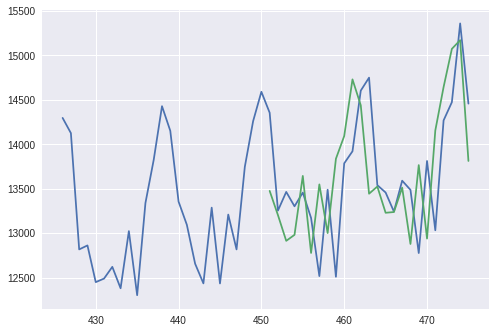

In [0]:
prediction = mdl.predict(start = electricity.gigawatts.values.shape[0] - 24, end = electricity.gigawatts.values.shape[0])
plt.plot(electricity.months.values[-50: ], electricity.gigawatts.values[-50: ])
plt.plot(electricity.months.values[-25: ], prediction)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:353: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend is None or trend == 'n':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:355: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'c':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:357: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 't':
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:359: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif trend == 'ct':


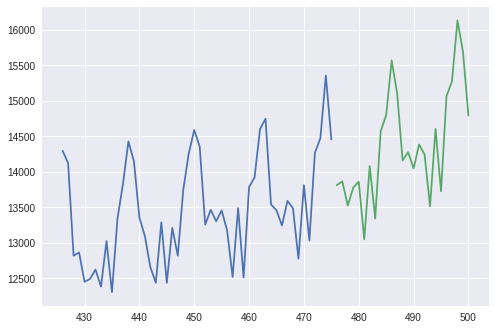

In [0]:
prediction = mdl.forecast(25)
plt.plot(electricity.months.values[-50: ], electricity.gigawatts.values[-50: ])
plt.plot(electricity.months.values[-25: ]+25, prediction)
plt.show()

# Что нам делать, как нам быть? 

*внимание на доску*

дополнительный ряд с которым можно поиграться

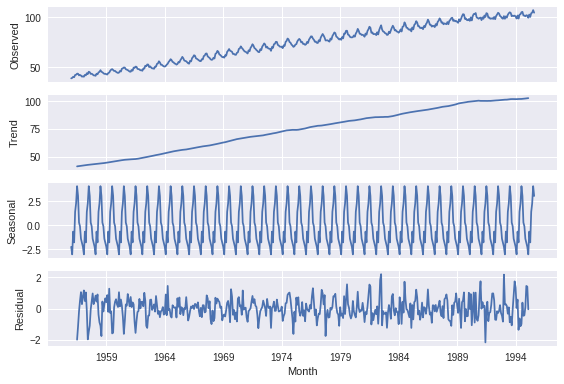

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
result = seasonal_decompose(electricity_2['gigawatts_box'], model='additive', freq=12)
result.plot()
plt.show()

In [0]:
dateparse_course = lambda x: pd.datetime.strptime(x, '%m/%d/%y')

course = pd.read_csv('/content/gdrive/My Drive/TechnoPark/TimeSeriesDataset/currency.csv', sep=',', index_col=['Time'], parse_dates=['Time'], date_parser=dateparse_course)
course.columns = ['gems']
course['days'] = course.reset_index().index
course.head()

,gems,days
Time,,
2017-05-01,1199436,0
2017-05-02,1045515,1
2017-05-03,586111,2
2017-05-04,856601,3
2017-05-05,793775,4


In [0]:
course.gems.plot()

In [0]:
result = seasonal_decompose(course['gems'], model='multiplicative')
result.plot()
plt.show()

In [0]:
print("Dickey-Fuller p-value:", sm.tsa.stattools.adfuller(result.resid[30:-30])[1])

Dickey-Fuller p-value: 9.042094252666834e-10


In [0]:
u